Neste case, você vai trabalhar com os algoritmos de arvore para fazer um treinamento de classificação usando ML;

* Faça a importação da base dados_class.csv;
* CRIE uma variável resposta binária de nome Saldo_Comercial_Flag com as classes "SUPERAVIT" e "DEFICIT" para a diferença na balança comercial do BRASIL;
* Use algum método de feature selection antes do processo de modelagem;
* Use as técnicas random_forest, decision_tree e XGBoost;
* Faça uso de métricas de qualidade e ajuste para entender qual modelo performou melhor;
* Faça a serialização do modelo vencedor com joblib;
* Crie um dado de exemplo e rode o predict do modelo;
* Explique o motivo de ter usado as tecnicas de qualidade e ajuste escolhidas;
* Notou algo estranho na base de dados? Em caso positivo, deixe isso bem sinalizado;
* Demonstre que seu modelo não overfitou, se aplicavel;

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('dados_class.csv')
df.head()

,Unnamed: 0,pib,renda,renda_per_capita,indice_consumidor,indice_produtor,taxa_cambio,taxa_desemprego,taxa_emprego,populacao_economicamente_ativa,...,exportacoes,importacoes,saldo_comercial,cobertura_comercial,divida_publica,despesa_fiscal,taxa_alfabetizacao,taxa_matricula_educacao,gastos_educacao,inflacao
0,2020-01-01,1.476107e+12,1.445311e+12,7910,172.774291,172.774291,5.155179,13.93,51.324,100641930,...,16.453552,15.848527,0.605025,0.605025,98.709882,38.481161,NaN,NaN,NaN,3.211768
1,2019-01-01,1.873288e+12,1.822994e+12,9220,167.397860,167.397860,3.944471,12.05,56.569,107415119,...,14.122919,14.767339,-0.644419,-0.644419,92.565253,34.787453,NaN,NaN,5.96347,3.732976
2,2018-01-01,1.916934e+12,1.863631e+12,9140,161.373814,161.373814,3.653825,12.46,55.903,105437485,...,14.634999,14.241204,0.393796,0.393796,86.607884,35.454000,93.227501,NaN,6.08851,3.664850
3,2017-01-01,2.063515e+12,2.024937e+12,8670,155.668786,155.668786,3.191389,12.93,55.542,104079618,...,12.518968,11.800767,0.718201,0.718201,83.669203,36.247654,93.075821,97.55117,6.32048,3.446373
4,2016-01-01,1.795693e+12,1.757597e+12,8890,150.482594,150.482594,3.491313,11.74,56.027,102278733,...,12.466679,12.067003,0.399676,0.399676,73.418804,36.491601,92.808441,97.20202,6.31404,8.739144


In [3]:
df.shape

(10031, 21)

 - Notou algo estranho na base de dados? Em caso positivo, deixe isso bem sinalizado;<br>
 A base apresenta um aspecto temporal atípico, onde há poucos dados do período de 1990 até 2020 e logo em seguida apresenta maiores informações por anomes de 2030 a 2057

In [4]:
# Transformação da data
df['data'] = pd.to_datetime(df['Unnamed: 0'], format='%Y-%m-%d')
df['ano'] = df['data'].dt.year
df.head()

,Unnamed: 0,pib,renda,renda_per_capita,indice_consumidor,indice_produtor,taxa_cambio,taxa_desemprego,taxa_emprego,populacao_economicamente_ativa,...,saldo_comercial,cobertura_comercial,divida_publica,despesa_fiscal,taxa_alfabetizacao,taxa_matricula_educacao,gastos_educacao,inflacao,data,ano
0,2020-01-01,1.476107e+12,1.445311e+12,7910,172.774291,172.774291,5.155179,13.93,51.324,100641930,...,0.605025,0.605025,98.709882,38.481161,NaN,NaN,NaN,3.211768,2020-01-01,2020
1,2019-01-01,1.873288e+12,1.822994e+12,9220,167.397860,167.397860,3.944471,12.05,56.569,107415119,...,-0.644419,-0.644419,92.565253,34.787453,NaN,NaN,5.96347,3.732976,2019-01-01,2019
2,2018-01-01,1.916934e+12,1.863631e+12,9140,161.373814,161.373814,3.653825,12.46,55.903,105437485,...,0.393796,0.393796,86.607884,35.454000,93.227501,NaN,6.08851,3.664850,2018-01-01,2018
3,2017-01-01,2.063515e+12,2.024937e+12,8670,155.668786,155.668786,3.191389,12.93,55.542,104079618,...,0.718201,0.718201,83.669203,36.247654,93.075821,97.55117,6.32048,3.446373,2017-01-01,2017
4,2016-01-01,1.795693e+12,1.757597e+12,8890,150.482594,150.482594,3.491313,11.74,56.027,102278733,...,0.399676,0.399676,73.418804,36.491601,92.808441,97.20202,6.31404,8.739144,2016-01-01,2016


In [5]:
df['id'] = df.index

In [6]:
# Drop colunas com data
df.drop(columns=['Unnamed: 0','data'], inplace=True)

In [7]:
df['saldo_comercial_flag'] = np.where(df['saldo_comercial']>=0.0, 'SUPERAVIT', 'DEFICIT')
df.drop(columns=['saldo_comercial'], inplace=True)

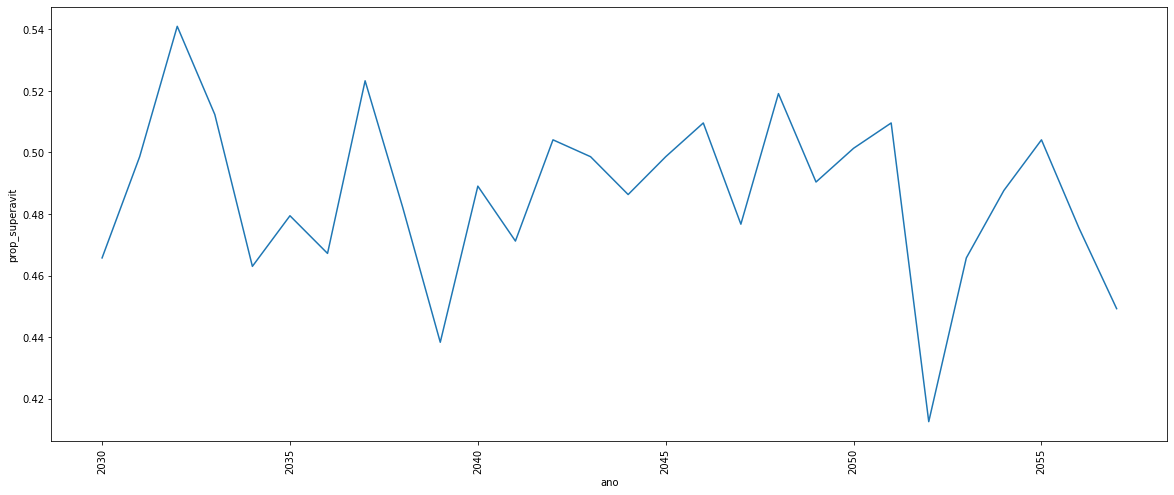

In [8]:
# Observar a proporção de superavit
# Quanto maior o valor, maior o superavit, quanto menor significa maior deficit
df_aux = df.groupby(['ano','saldo_comercial_flag'])['id'].count().unstack()
df_aux['prop_superavit'] = df_aux['SUPERAVIT']/(df_aux['SUPERAVIT'] + df_aux['DEFICIT'])
#df_aux['prop_superavit'].fillna(0, inplace=True)
fig, ax = plt.subplots(figsize = (20,8))
sns.lineplot(data = df_aux, ax=ax, x='ano', y='prop_superavit')
plt.xticks(rotation=90)
plt.show()

## EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10031 entries, 0 to 10030
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pib                             10031 non-null  float64
 1   renda                           10031 non-null  float64
 2   renda_per_capita                10031 non-null  int64  
 3   indice_consumidor               10031 non-null  float64
 4   indice_produtor                 10031 non-null  float64
 5   taxa_cambio                     10031 non-null  float64
 6   taxa_desemprego                 9678 non-null   float64
 7   taxa_emprego                    9678 non-null   float64
 8   populacao_economicamente_ativa  10031 non-null  int64  
 9   rendimento_medio_trabalhadores  8735 non-null   float64
 10  exportacoes                     10031 non-null  float64
 11  importacoes                     10031 non-null  float64
 12  cobertura_comercial             

In [10]:
df = df.dropna(thresh=df.shape[0]*0.55,how='all',axis=1)

In [11]:
df.columns

Index(['pib', 'renda', 'renda_per_capita', 'indice_consumidor',
       'indice_produtor', 'taxa_cambio', 'taxa_desemprego', 'taxa_emprego',
       'populacao_economicamente_ativa', 'rendimento_medio_trabalhadores',
       'exportacoes', 'importacoes', 'cobertura_comercial', 'gastos_educacao',
       'inflacao', 'ano', 'id', 'saldo_comercial_flag'],
      dtype='object')

In [12]:
def histogram(col):
    
    df.loc[df['saldo_comercial_flag']=='SUPERAVIT', col].hist(bins=50)
    plt.show()
    df.loc[df['saldo_comercial_flag']=='DEFICIT', col].hist(bins=50)
    plt.show()
    df[col].hist(bins=50)
    plt.show()
    
def grafico_linhas(col):
    fig, ax = plt.subplots(figsize=(12,8))
    if col == 'inflacao':
        df[df['ano']>=2030].groupby(['ano','saldo_comercial_flag'])[col].median().unstack().plot(ax=ax)
    else:
        df.groupby(['ano','saldo_comercial_flag'])[col].median().unstack().plot(ax=ax)
        
    plt.title(col)
    plt.show()
    
def box_plot(col):
    df.boxplot(column=[col], by=['ano','saldo_comercial_flag'], showfliers=False, figsize=(20,5), rot=90)
    plt.title('')
    plt.show()

### PIB

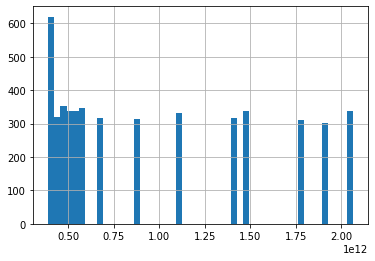

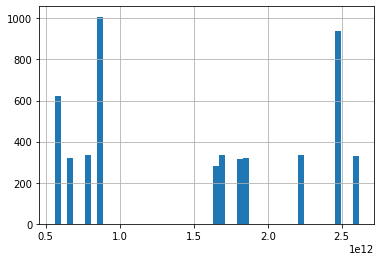

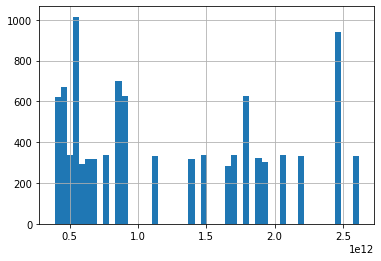

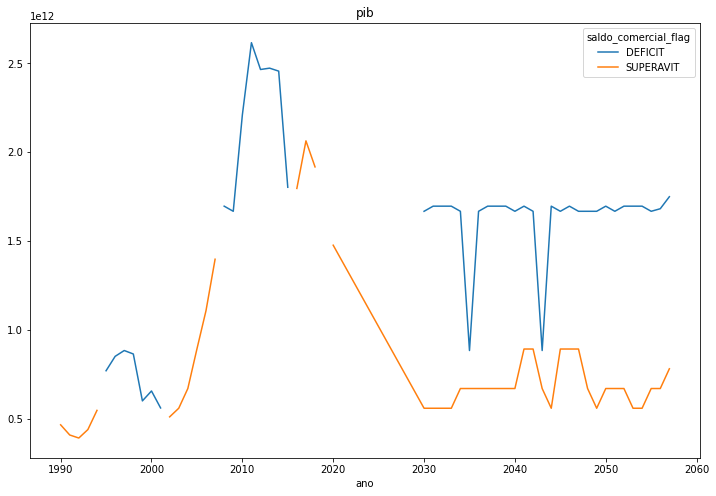

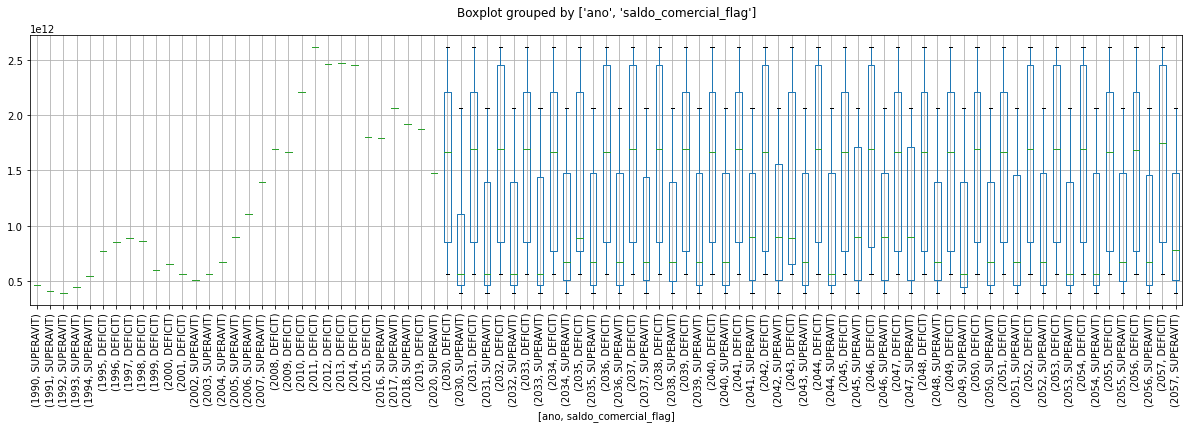

In [13]:
col = 'pib'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Renda

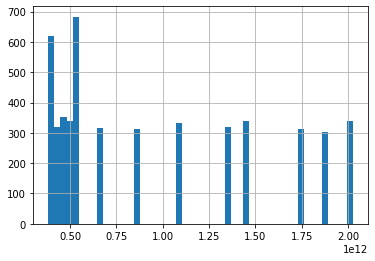

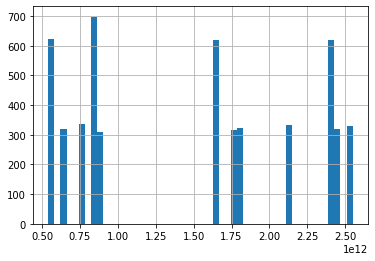

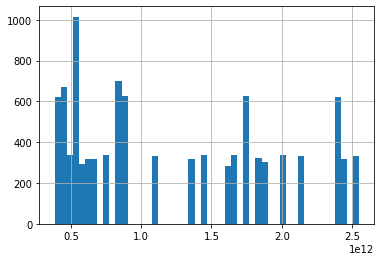

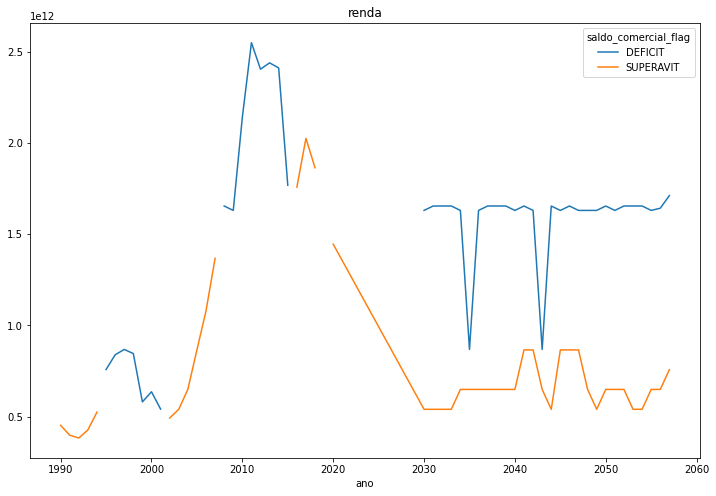

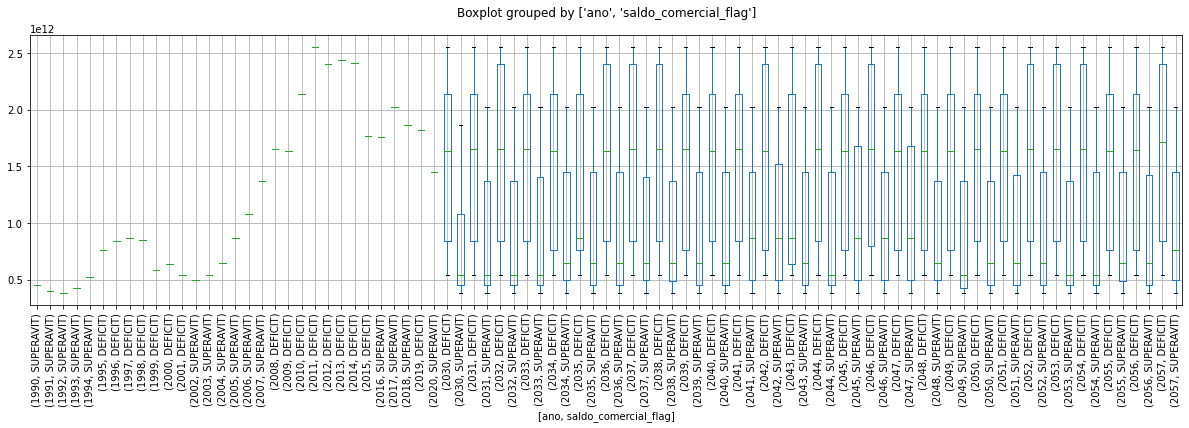

In [14]:
col = 'renda'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Renda per capita

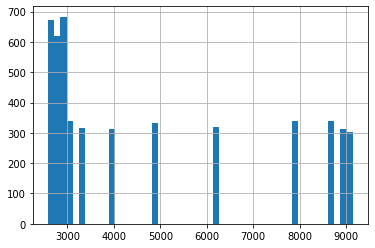

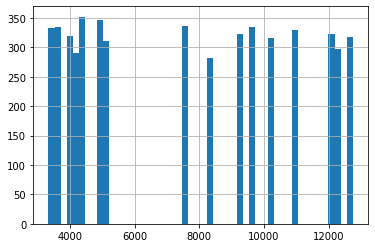

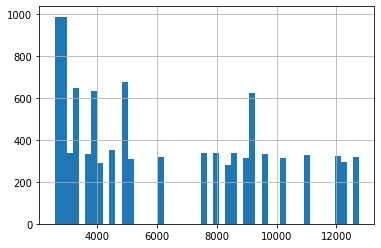

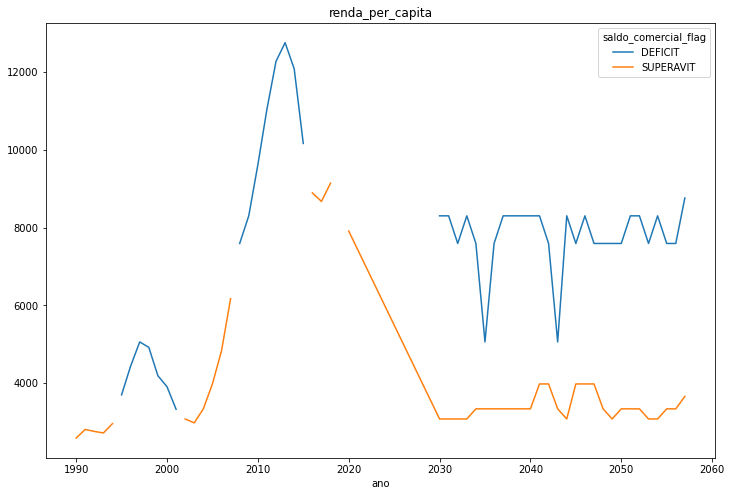

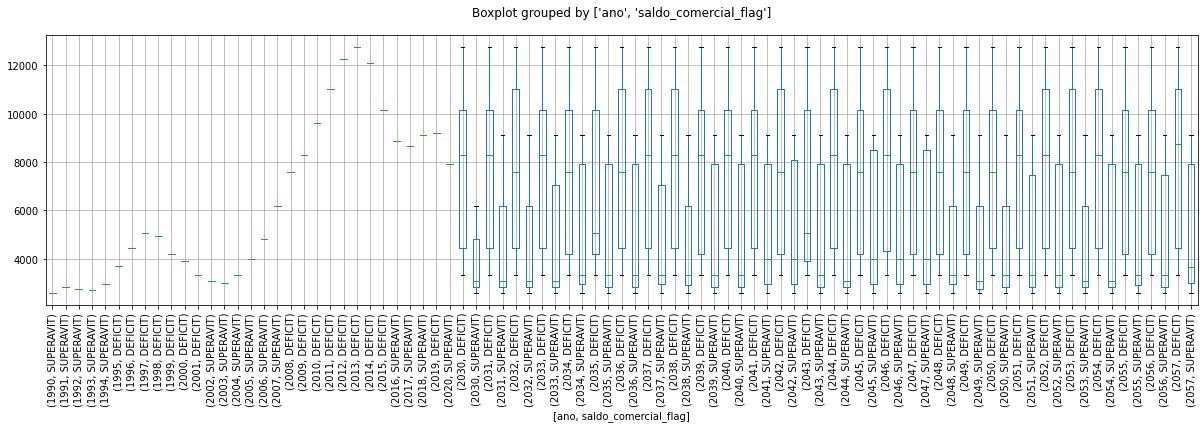

In [15]:
col = 'renda_per_capita'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Indice consumidor

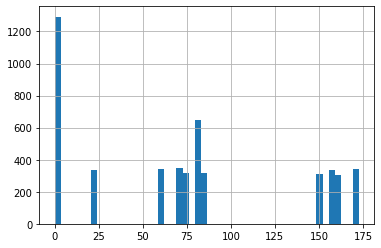

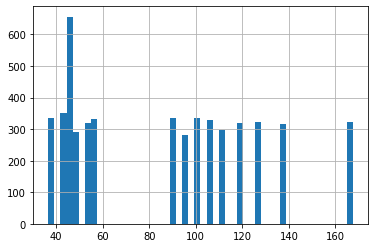

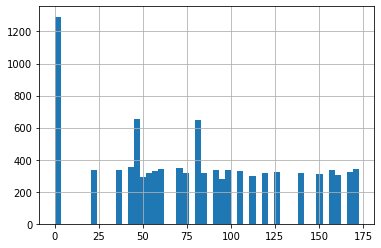

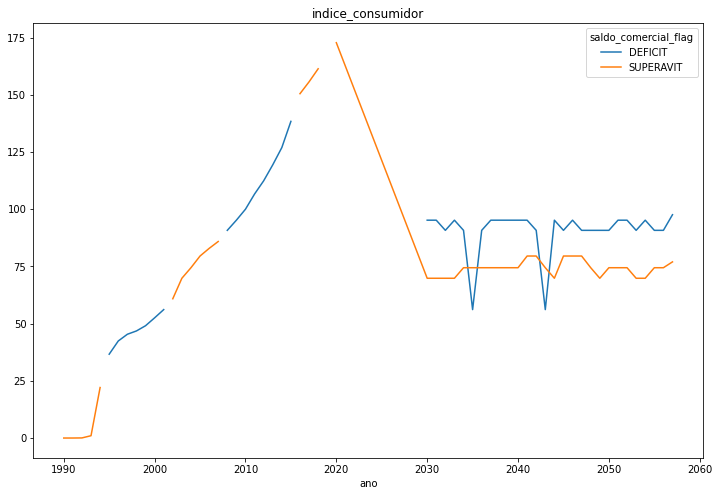

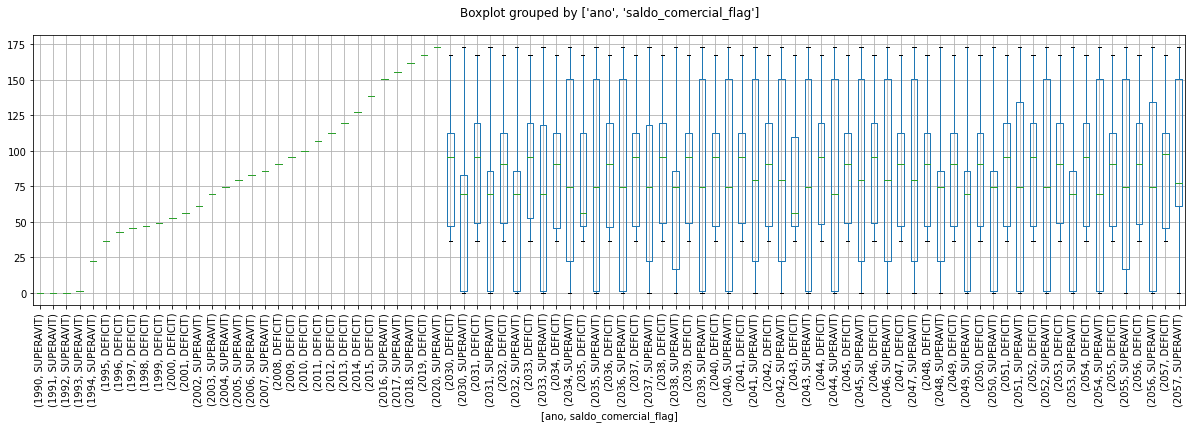

In [16]:
col = 'indice_consumidor'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Taxa cambio

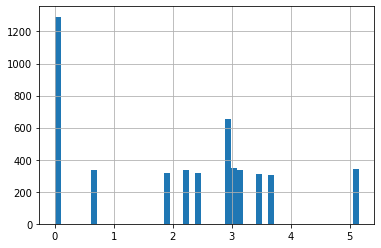

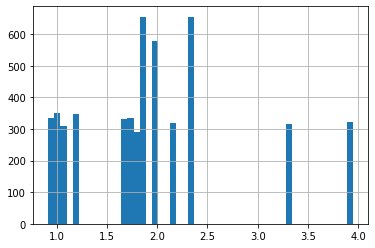

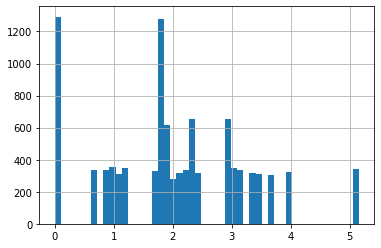

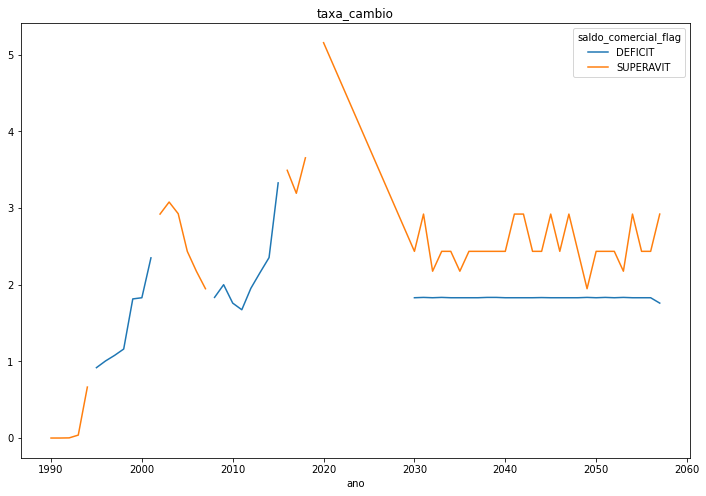

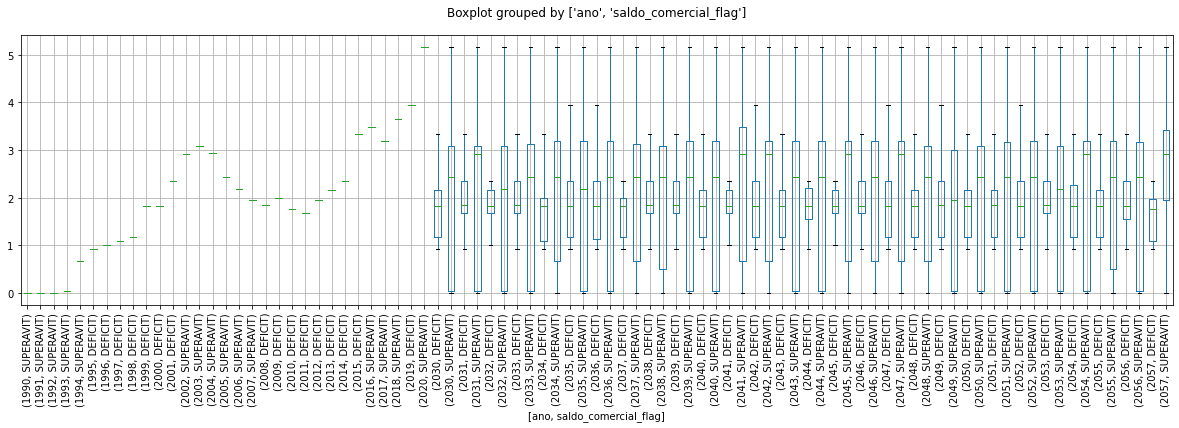

In [17]:
col = 'taxa_cambio'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Taxa desemprego

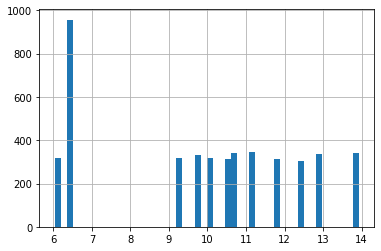

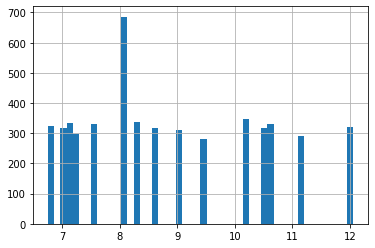

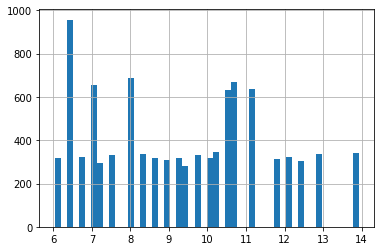

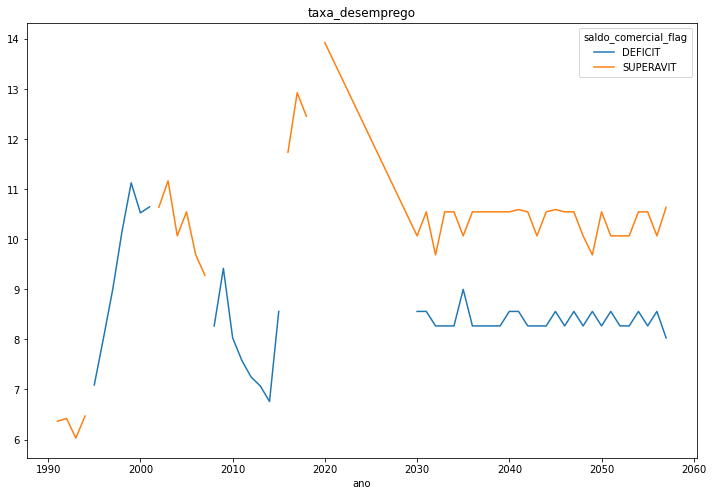

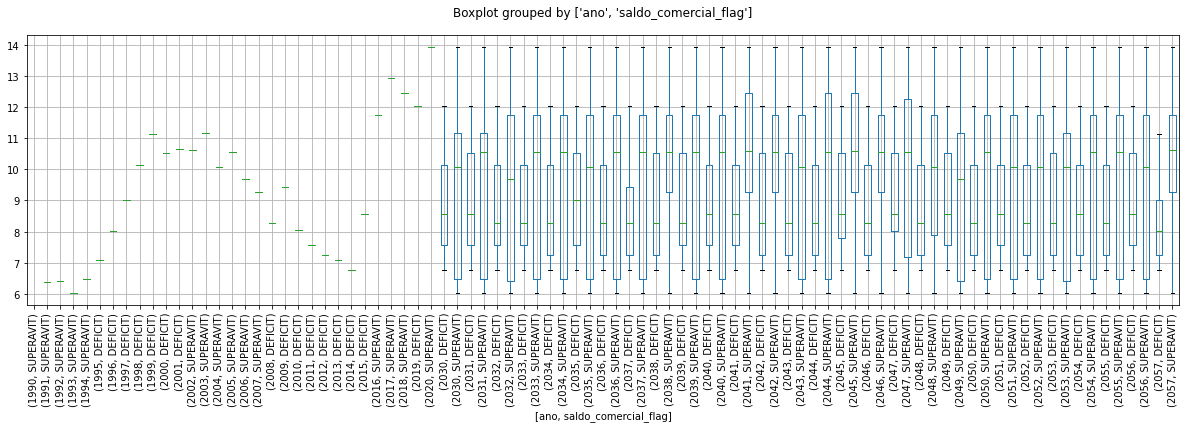

In [18]:
# Tem nulos
col = 'taxa_desemprego'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Taxa emprego

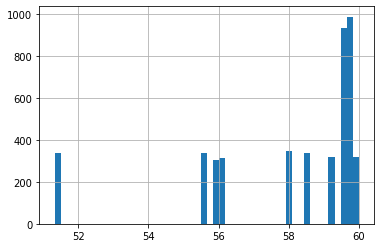

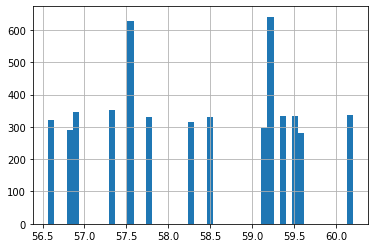

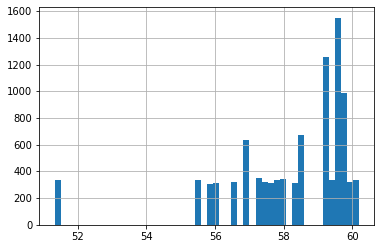

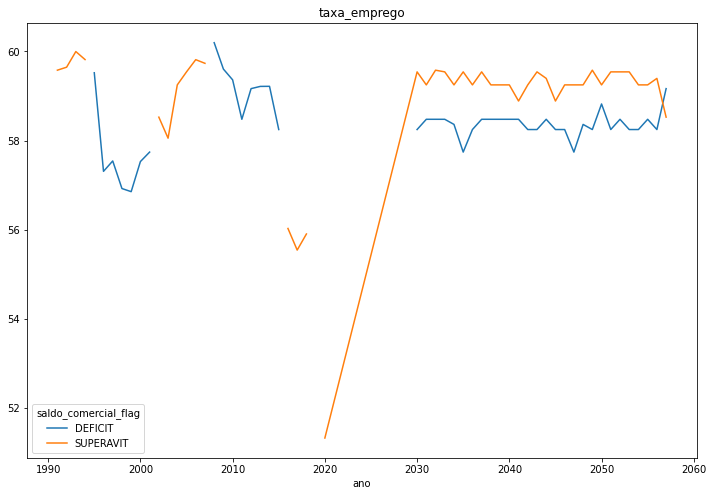

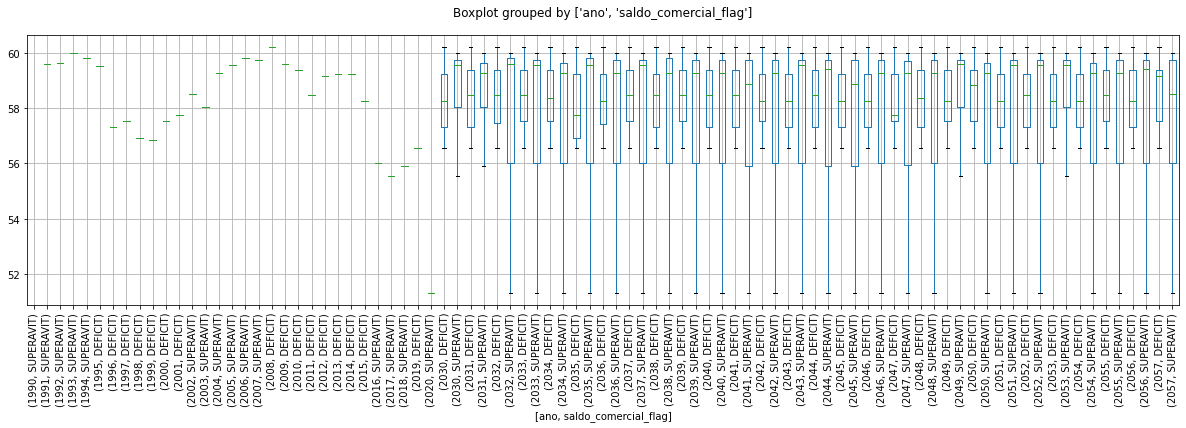

In [19]:
# Tem nulos
col = 'taxa_emprego'
histogram(col)
grafico_linhas(col)
box_plot(col)

## População Economicamente Ativa

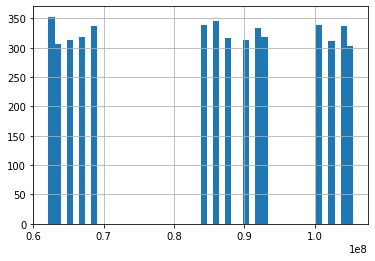

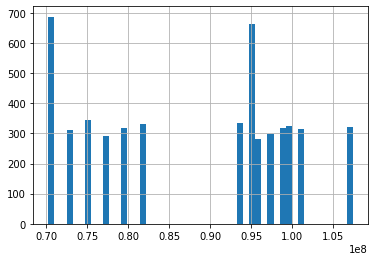

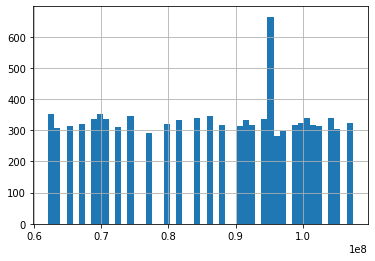

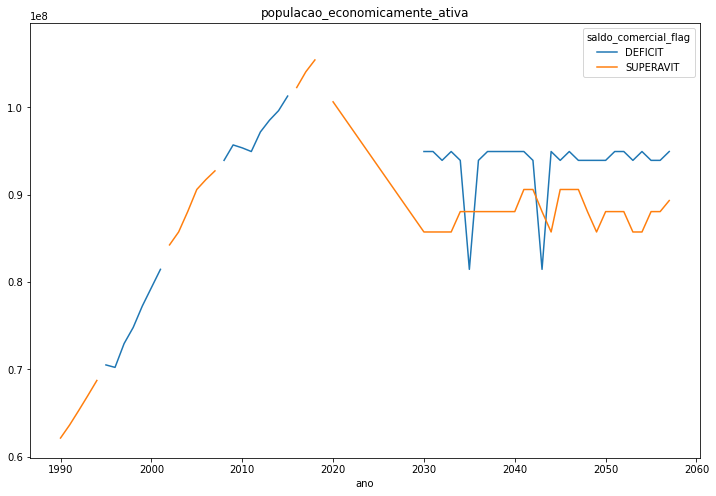

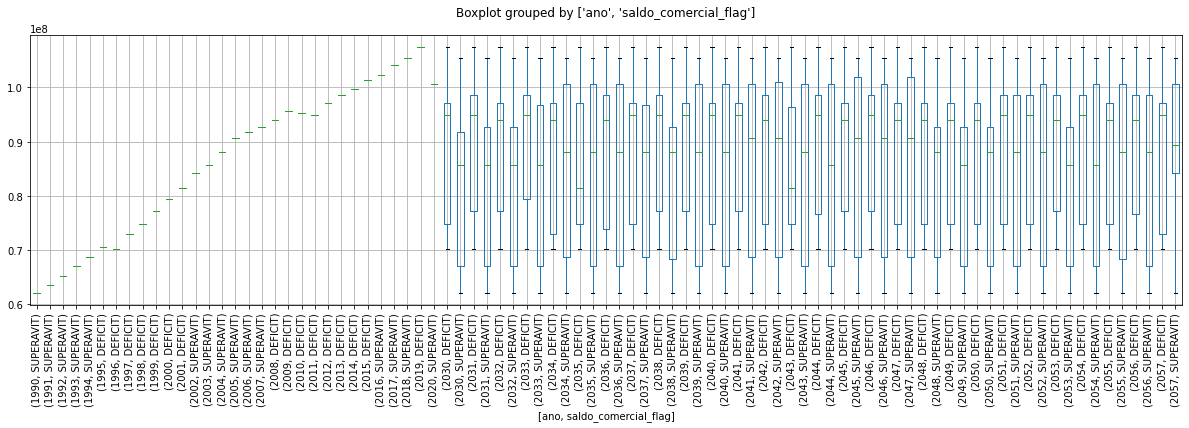

In [20]:
col = 'populacao_economicamente_ativa'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Rendimento medio trabalhadores

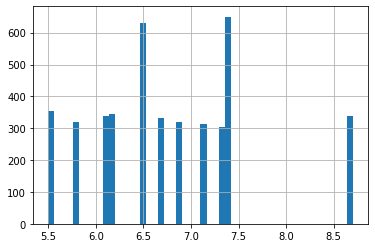

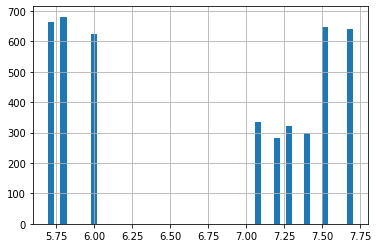

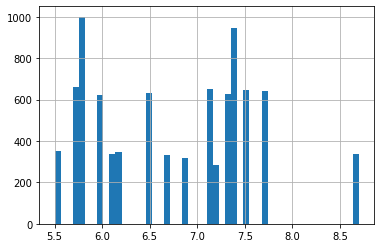

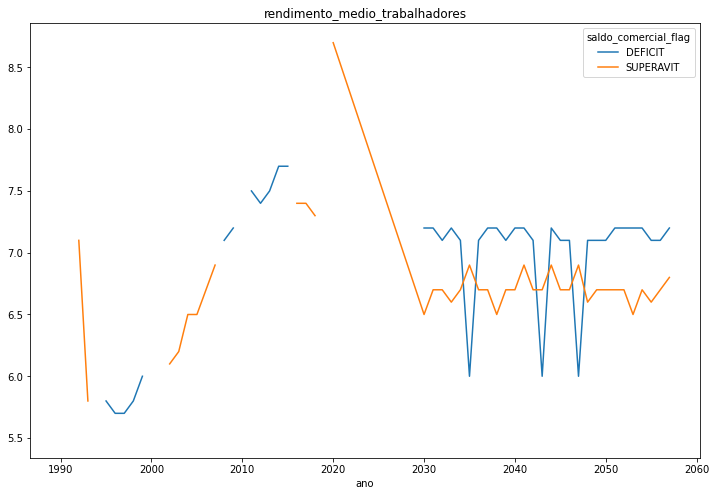

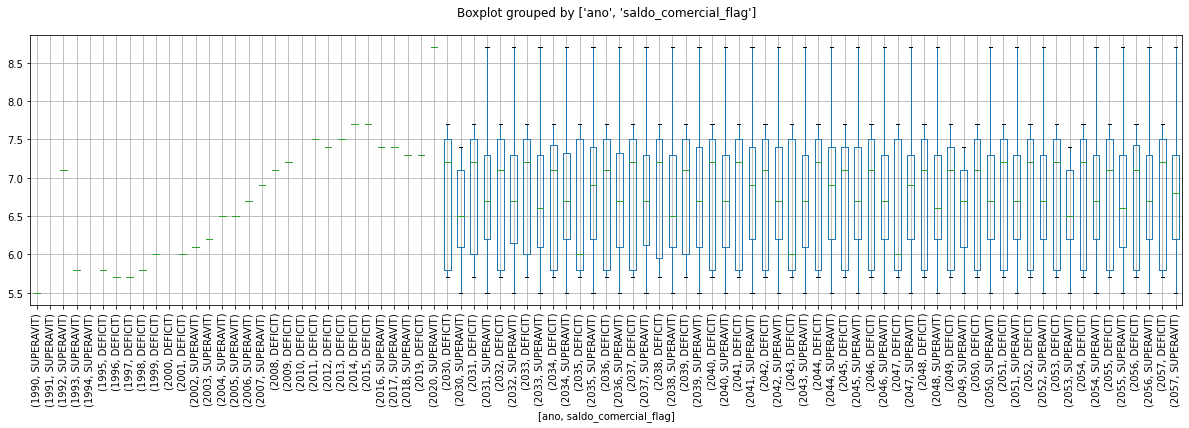

In [21]:
# Tem nulos
col = 'rendimento_medio_trabalhadores'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Exportações

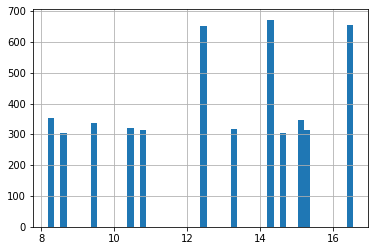

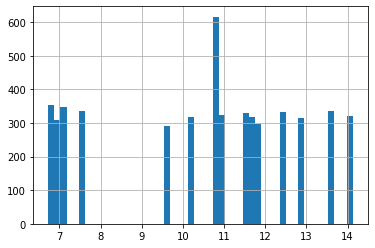

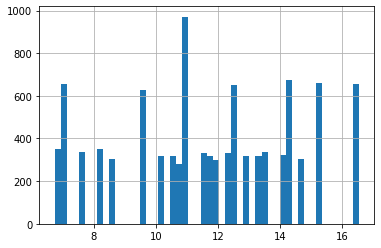

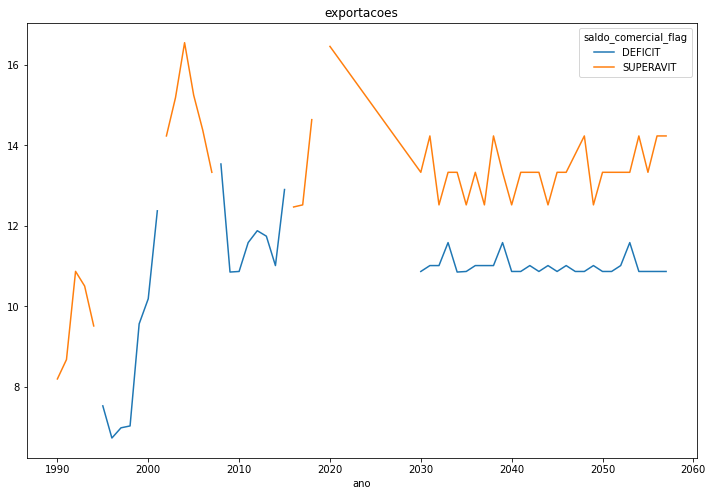

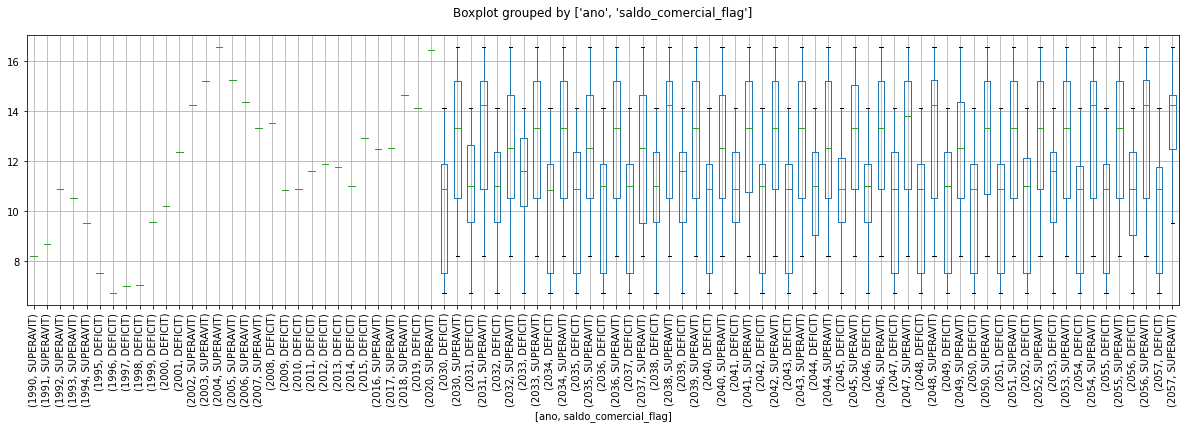

In [22]:
col = 'exportacoes'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Importações

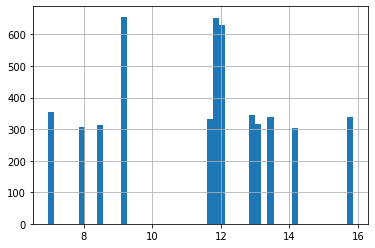

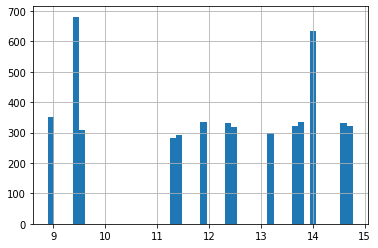

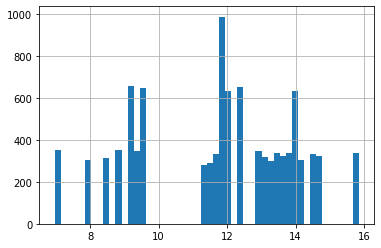

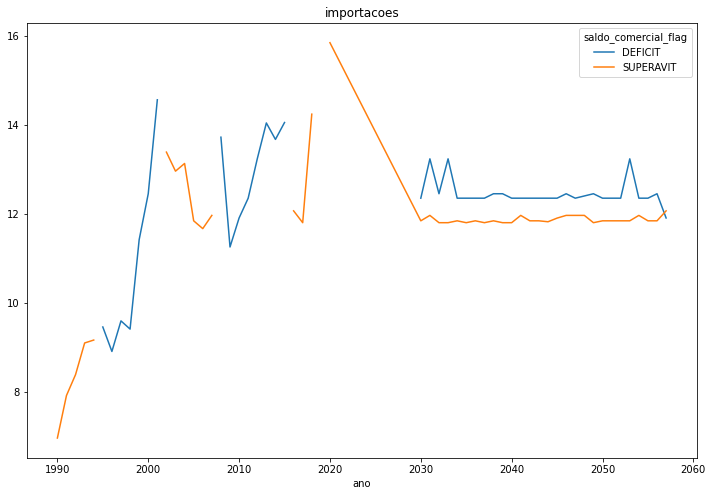

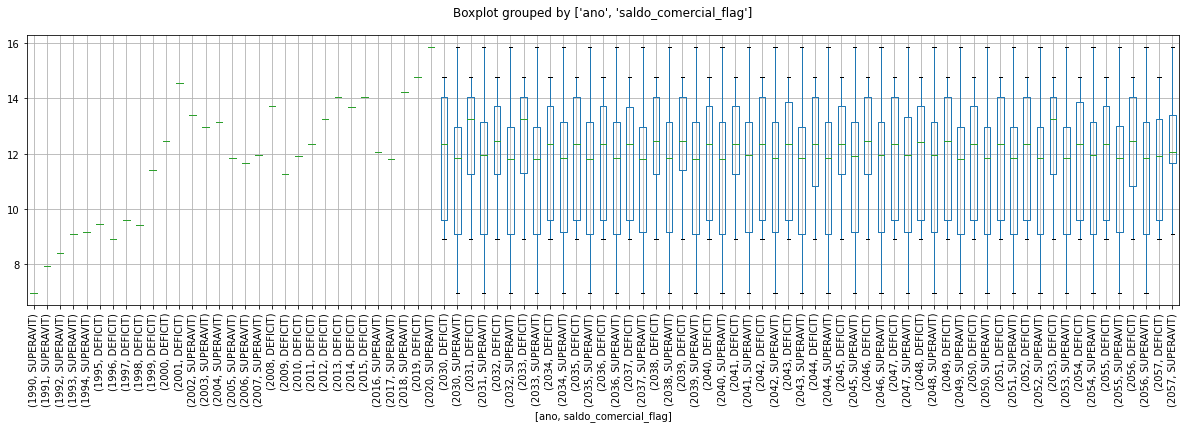

In [23]:
col = 'importacoes'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Cobertura comercial

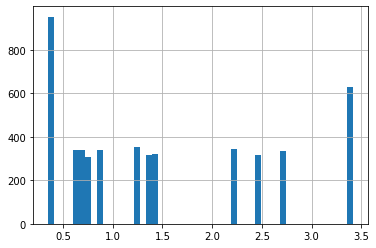

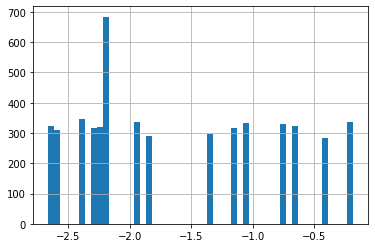

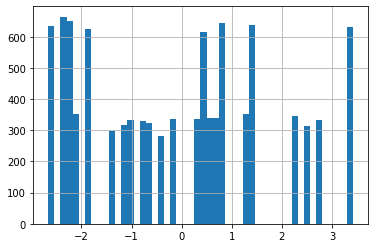

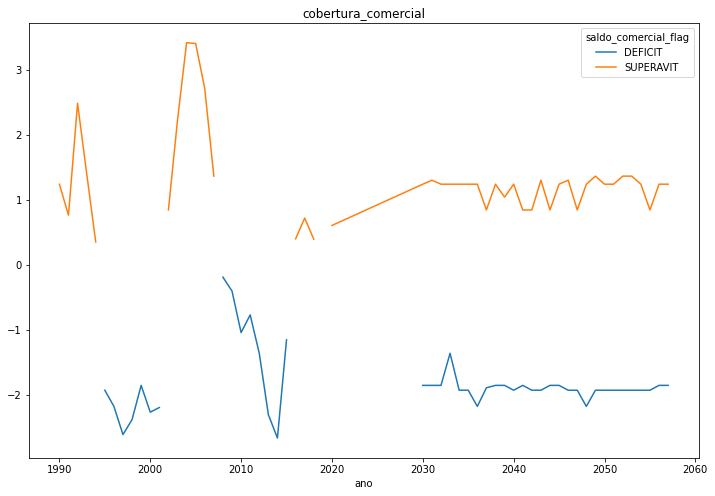

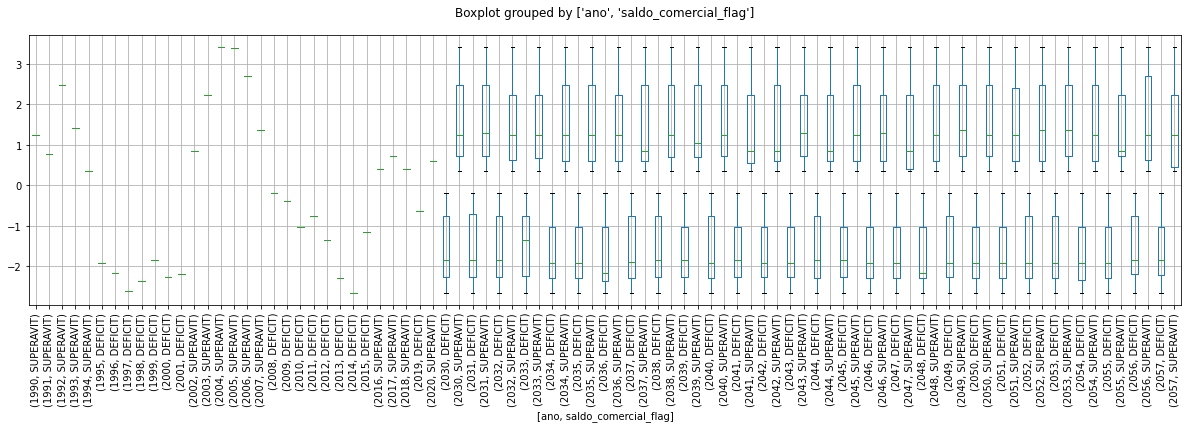

In [24]:
col = 'cobertura_comercial'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Gastos educação

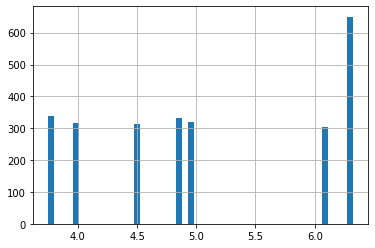

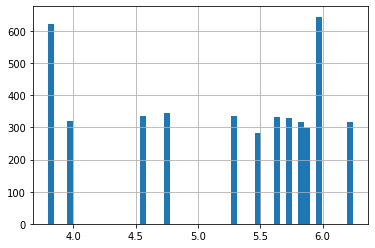

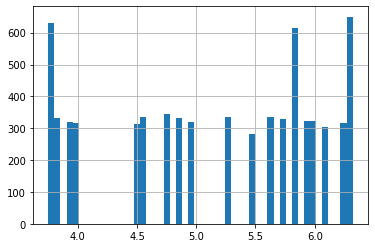

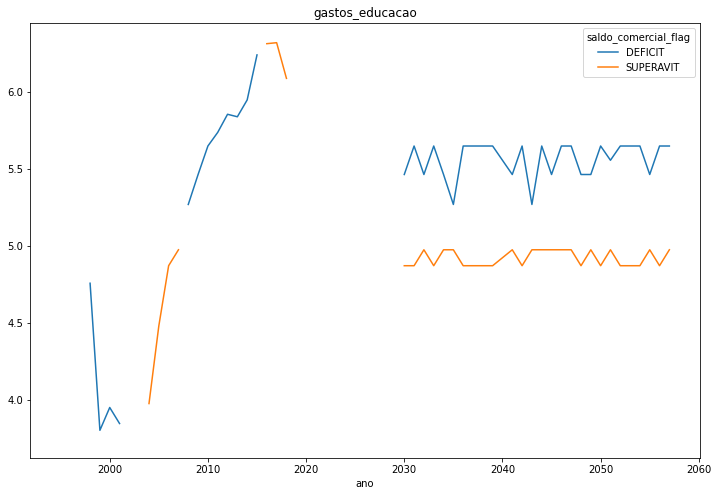

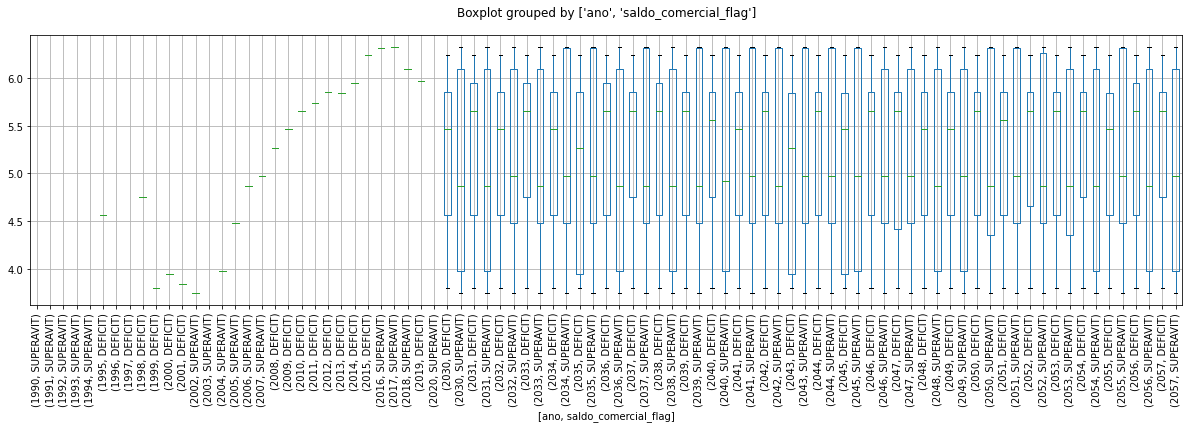

In [25]:
# Tem nulos
col = 'gastos_educacao'
histogram(col)
grafico_linhas(col)
box_plot(col)

## Inflação

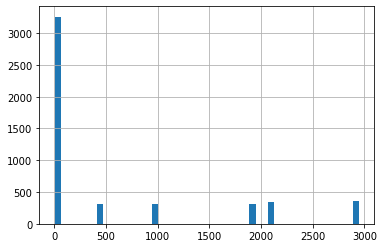

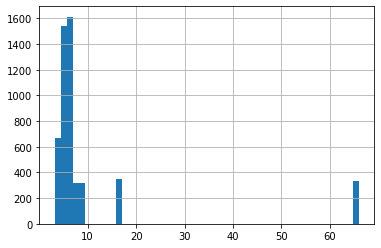

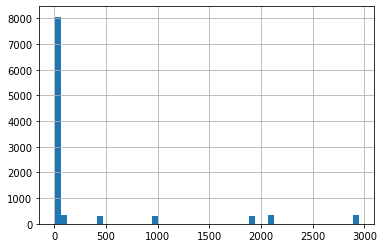

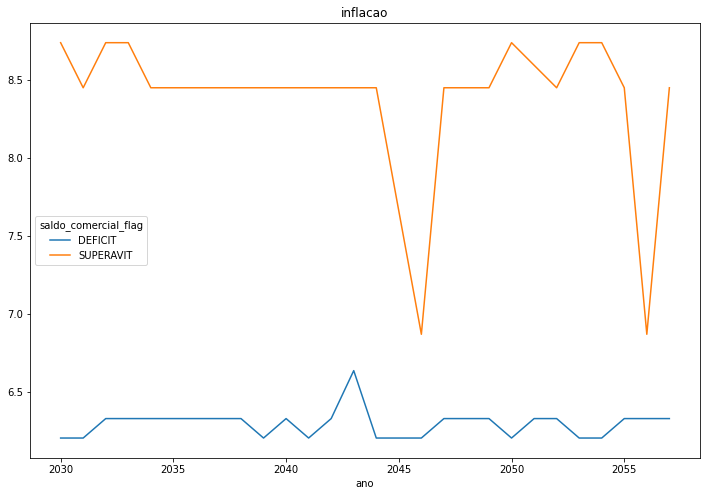

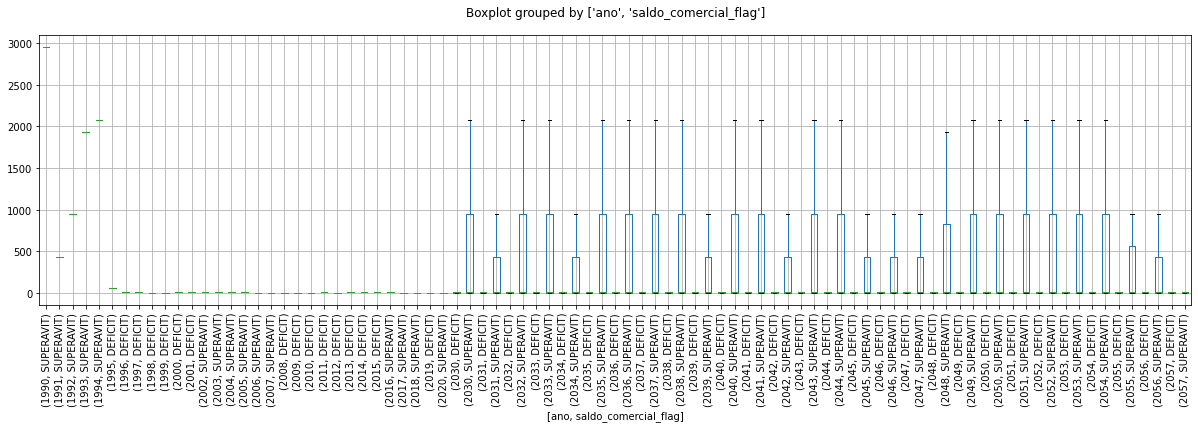

In [26]:
col = 'inflacao'
histogram(col)
grafico_linhas(col)
box_plot(col)

Como as variáveis que contém nulos não apresentam uma distribuição normal (para substituir os nulos por media ou mediana) e sem muito conhecimento sobre as variáveis, a substituição dos nulos foi feita pelo valor -1.

**Dúvida: sobre o método de preenchimento dos nulos em que cria um modelo para prever a resposta dos dados nulos <br> O que fazer, quando há mais de uma coluna com dados nulos?**

In [27]:
df['taxa_desemprego'].fillna(-1, inplace=True)
df['taxa_emprego'].fillna(-1, inplace=True)
df['rendimento_medio_trabalhadores'].fillna(-1, inplace=True)
df['gastos_educacao'].fillna(-1, inplace=True)

## Análise multivariada

In [28]:
def analise_multivariada(col1, col2):
    sns.scatterplot(df, x=col1, y=col2, hue='saldo_comercial_flag')
    sns.rugplot(df, x=col1, y=col2, hue='saldo_comercial_flag')

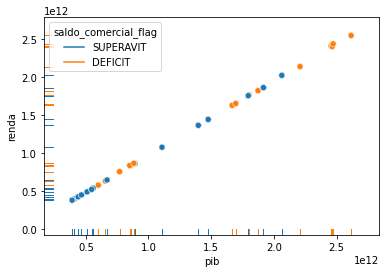

In [29]:
analise_multivariada('pib', 'renda')

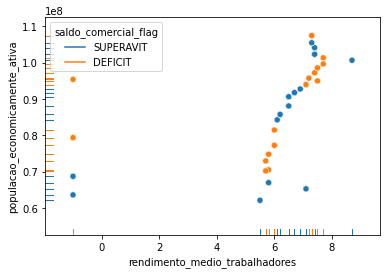

In [33]:
analise_multivariada('rendimento_medio_trabalhadores', 'populacao_economicamente_ativa')

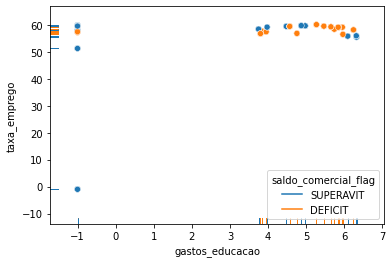

In [37]:
analise_multivariada('gastos_educacao', 'taxa_emprego')

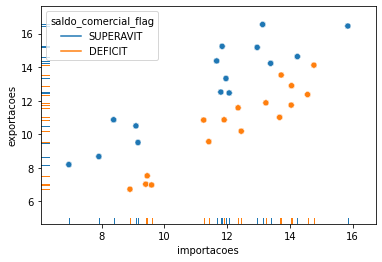

In [32]:
analise_multivariada('importacoes', 'exportacoes')

## Correlação dos dados

In [38]:
def correlation(corr_matrix):

    plt.figure(figsize=(10,10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns.values,
               yticklabels=corr_matrix.columns.values, cmap=cmap, vmax=1, center=0, square=True, annot=True, linewidths=.5, cbar_kws={'shrink':.82})
    plt.title('Heatmap of correlation matrix')

In [39]:
df['superavit_flag'] = np.where(df['saldo_comercial_flag']=='SUPERAVIT',1,0)

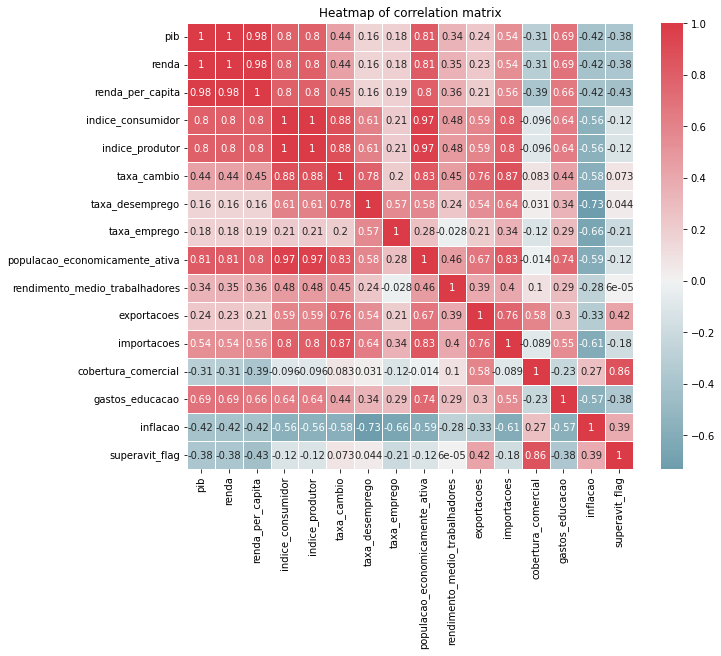

In [40]:
correlation(df[['pib', 'renda', 'renda_per_capita', 'indice_consumidor',
       'indice_produtor', 'taxa_cambio', 'taxa_desemprego', 'taxa_emprego',
       'populacao_economicamente_ativa', 'rendimento_medio_trabalhadores',
       'exportacoes', 'importacoes', 'cobertura_comercial', 'gastos_educacao',
       'inflacao', 'superavit_flag']].corr())

In [41]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif,mutual_info_regression

**Dúvida: a seleção de features é feita antes ou depois da divisão entre treino e teste?**

In [42]:
# Separação entre treino e test
X = df[['pib', 'renda', 'renda_per_capita', 'indice_consumidor',
       'indice_produtor', 'taxa_cambio', 'taxa_desemprego', 'taxa_emprego',
       'populacao_economicamente_ativa', 'rendimento_medio_trabalhadores',
       'exportacoes', 'importacoes', 'cobertura_comercial', 'gastos_educacao',
       'inflacao']]
y = df['superavit_flag']

X_train, X_test,y_train, y_test = train_test_split(X,y,
                                   random_state=42, 
                                   test_size=0.3, 
                                   shuffle=True)

## Feature Selection

#### SelectFromModel

In [49]:
estimator = linear_model.LogisticRegression(penalty="l1",solver="liblinear")
selector = SelectFromModel(estimator)
selector = selector.fit(X_train, y_train)
status = selector.get_support()

/home/rosana/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [50]:
X_train.columns

Index(['pib', 'renda', 'renda_per_capita', 'indice_consumidor',
       'indice_produtor', 'taxa_cambio', 'taxa_desemprego', 'taxa_emprego',
       'populacao_economicamente_ativa', 'rendimento_medio_trabalhadores',
       'exportacoes', 'importacoes', 'cobertura_comercial', 'gastos_educacao',
       'inflacao'],
      dtype='object')

In [51]:
print("Features selecionadas:")
print(X_train.columns[status])

Features selecionadas:
Index(['renda_per_capita', 'indice_consumidor', 'indice_produtor',
       'taxa_desemprego', 'taxa_emprego', 'importacoes', 'cobertura_comercial',
       'inflacao'],
      dtype='object')


In [52]:
X_train_sample = pd.DataFrame(selector.transform(X_train), columns=X_train.columns[status])
X_test_sample = pd.DataFrame(selector.transform(X_test), columns=X_test.columns[status])

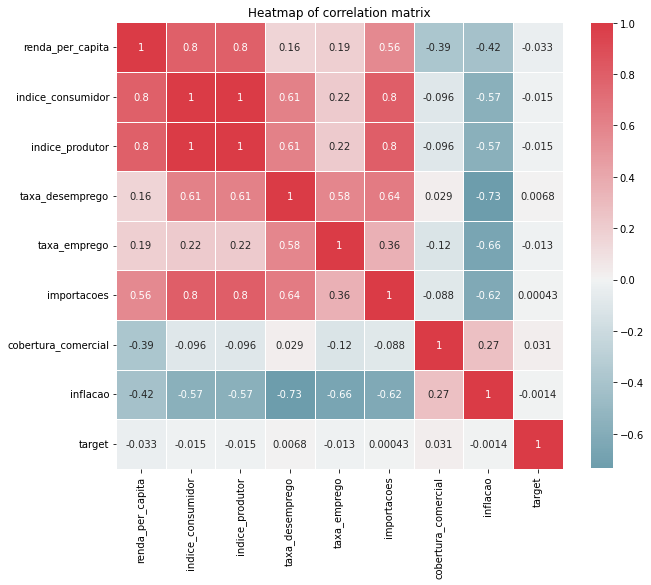

In [53]:
# Avaliar correlação após seleção de features
aux = X_train_sample.copy()
aux['target'] = y_train
correlation(aux.corr())

#### Remoção por corte de correlação

In [54]:
corr = X_train.corr()
features = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.7).any()
features

pib                               False
renda                             False
renda_per_capita                  False
indice_consumidor                 False
indice_produtor                   False
taxa_cambio                       False
taxa_desemprego                   False
taxa_emprego                       True
populacao_economicamente_ativa    False
rendimento_medio_trabalhadores     True
exportacoes                       False
importacoes                       False
cobertura_comercial                True
gastos_educacao                   False
inflacao                          False
dtype: bool

/tmp/ipykernel_1988/2995760859.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['target'] = y_train


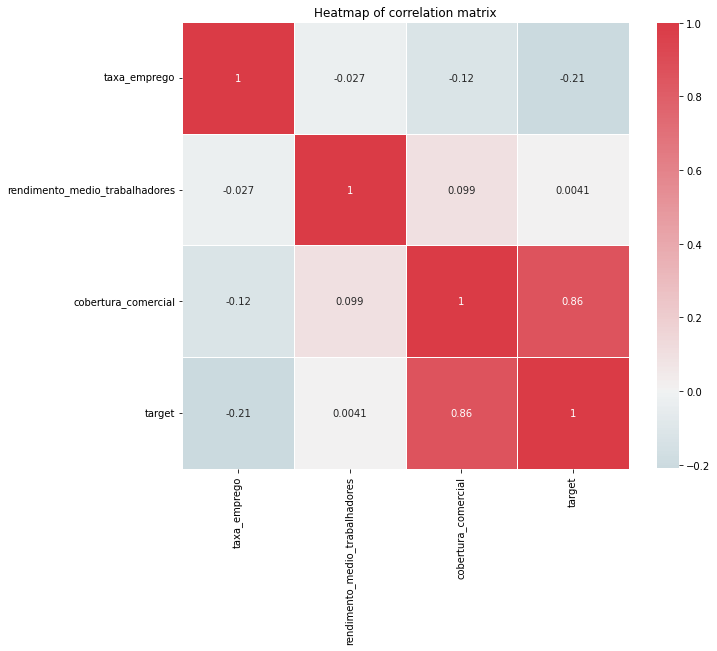

In [69]:
# Avaliando após seleção de features
aux = X_train.loc[:,list(features.values)]
aux['target'] = y_train
correlation(aux.corr())

#### SelectKBest

In [84]:
selector = SelectKBest(f_classif, k=4)
selector.fit(X_train, y_train)
# Selecionar features
cols_idxs = selector.get_support(indices=True)

/tmp/ipykernel_1988/2677379991.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['target'] = y_train


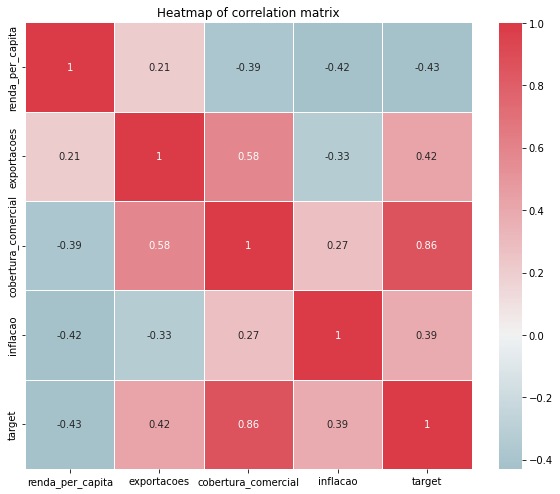

In [85]:
# Avaliar correlação após seleção de features
aux = X_train.iloc[:,cols_idxs]
aux['target'] = y_train
correlation(aux.corr())

In [100]:
X_train_sample = X_train.iloc[:,np.delete(cols_idxs, np.where(cols_idxs == 12))]
X_test_sample = X_test.iloc[:,np.delete(cols_idxs, np.where(cols_idxs == 12))]

Avaliando as três técnicas acima para feature selection, serão utilizadas as features encontradas pela técnica SelectKBest, com 4 melhores features: renda_per_capita, exportacoes, cobertura_comercial, inflacao. Entretanto
Cobertura_comercial foi removida por representar uma correlação forte com a target, com 86% de correlação, a variável por si só já explicaria a saída/resultado da target.

## Modelagem

In [103]:
def confusionmatrix(clf, y_test, y_pred):
    color = 'black'
    matrix = plot_confusion_matrix(clf, X_test_sample, y_test, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix', color=color)
    plt.xlabel('Predicted Label', color=color)
    plt.ylabel('True Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()

### Árvore de decisão

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, roc_auc_score

In [114]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train_sample,y_train)

y_pred_train = clf.predict(X_train_sample)
y_pred = clf.predict(X_test_sample)

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97      1575
           1       0.93      1.00      0.97      1435

    accuracy                           0.97      3010
   macro avg       0.97      0.97      0.97      3010
weighted avg       0.97      0.97      0.97      3010



In [ ]:
# Métricas 
acuracia = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp + fp)
recall = tp/(tp + fn)

/home/rosana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


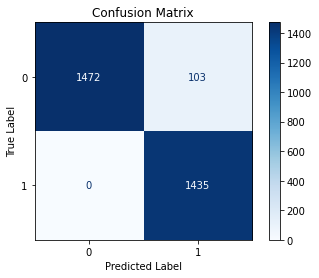

In [116]:
confusionmatrix(clf, y_test, y_pred)

In [117]:
# Análise de overfitting através da roc auc
print("ROC AUC para treino: ", roc_auc_score(y_train, y_pred_train))
print("ROC AUC para teste: ", roc_auc_score(y_test, y_pred))

ROC AUC para treino:  0.9673486547085202
ROC AUC para teste:  0.9673015873015873


## Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier

In [125]:
rf = RandomForestClassifier(n_estimators=300, max_depth=3)
rf = rf.fit(X_train_sample,y_train)

y_pred_train = rf.predict(X_train_sample)
y_pred = rf.predict(X_test_sample)

In [126]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1575
           1       1.00      0.94      0.97      1435

    accuracy                           0.97      3010
   macro avg       0.97      0.97      0.97      3010
weighted avg       0.97      0.97      0.97      3010



/home/rosana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


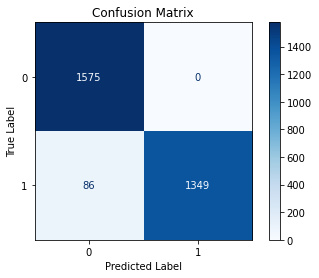

In [127]:
confusionmatrix(rf, y_test, y_pred)

In [128]:
# Análise de overfitting através da roc auc
print("ROC AUC para treino: ", roc_auc_score(y_train, y_pred_train))
print("ROC AUC para teste: ", roc_auc_score(y_test, y_pred))

ROC AUC para treino:  0.9672748334781349
ROC AUC para teste:  0.970034843205575


## XGBoost

In [129]:
import xgboost as xgb

In [138]:
xg = xgb.XGBClassifier(n_estimators=300,reg_lambda=1,gamma=0.01,max_depth=3)
xg = xg.fit(X_train_sample,y_train)

y_pred_train = xg.predict(X_train_sample)
y_pred = xg.predict(X_test_sample)

In [139]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1575
           1       1.00      1.00      1.00      1435

    accuracy                           1.00      3010
   macro avg       1.00      1.00      1.00      3010
weighted avg       1.00      1.00      1.00      3010



/home/rosana/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


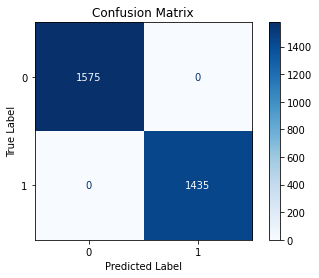

In [140]:
confusionmatrix(xg, y_test, y_pred)

In [141]:
# Análise de overfitting através da roc auc
print("ROC AUC para treino: ", roc_auc_score(y_train, y_pred_train))
print("ROC AUC para teste: ", roc_auc_score(y_test, y_pred))

ROC AUC para treino:  1.0
ROC AUC para teste:  1.0


Os três modelos utilizados tiveram bons resultados de acurácia, recall, precision, boa distribuição entre falsos e verdadeiros positivos/negativos avaliados através da matriz de confusão. Além disso, também apresentaram altos valores de roc_auc tanto para os dados de treinamento quanto para os dados de teste, o que indica que não houve overfitting em nenhum modelo. O overfitting ocorreria se o roc_score da base de treino fosse alto (i.e 80%) e o roc_score da base de teste fosse baixo (i.e 60%).

## Salvando modelo vencedor

In [142]:
# Modelo vencedor foi o XGBOOST por apresentar maiores valores das métricas utilizadas
import joblib

filename = "xgboost_model.joblib"

# save model
joblib.dump(xg, filename)

['xgboost_model.joblib']

### Criando um exemplo para o modelo

In [156]:
exemplo = pd.DataFrame({'renda_per_capita':[4000, 50000],'exportacoes':[9,120],'inflacao':[12,88]})

In [157]:
xg.predict(exemplo)

array([0, 1])

0: deficit
1: superavit

**Dúvida:** Seria válido transformar os dados numéricos em categóricos? Se sim, o ideal é fazer a selação comum com os dados numéricos até chegar nas 3 variáveis e em seguida categorizar ou categorizar todas as 15 variáveis iniciais?